# Initialize Notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm, Normalize
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap
import matplotlib.patheffects as pe
from mpl_toolkits.mplot3d import Axes3D
import ROOT
import uproot
import os
import sys
import copy
import tqdm
import pandas as pd
import pickle as pkl
from sklearn.decomposition import PCA

%jsroot on
# %matplotlib qt
%matplotlib inline

Welcome to JupyROOT 6.30/02


In [2]:
sys.path.append('../python/')
from filterMethods import *
from gridMethods import *
# from trackReconstructionMethods import *
from hitAccuracyMethods import *
from statisticsMethods import *
from importMethods import *
from constants import *
import plotParameters

In [3]:
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'

# Load Data

In [4]:
# fileName = '../runs/event_2mu100MeVBackToBack_usedForTrackReconstruction.root'
fileName = '../build/event.root'
histDir = '/photoSensor_hits_histograms'
print(get_histogram_names    (fileName, histDir))
print(get_histogram_titles   (fileName, histDir))
print(get_histogram_positions(fileName, histDir))
print(get_histogram_walls    (fileName, histDir))

['photoSensor_0;1', 'photoSensor_1;1', 'photoSensor_2;1', 'photoSensor_3;1', 'photoSensor_4;1', 'photoSensor_5;1', 'photoSensor_6;1', 'photoSensor_7;1', 'photoSensor_8;1', 'photoSensor_9;1', 'photoSensor_10;1', 'photoSensor_11;1', 'photoSensor_12;1', 'photoSensor_13;1', 'photoSensor_14;1', 'photoSensor_15;1', 'photoSensor_16;1', 'photoSensor_17;1', 'photoSensor_18;1', 'photoSensor_19;1', 'photoSensor_20;1', 'photoSensor_21;1', 'photoSensor_22;1', 'photoSensor_23;1', 'photoSensor_24;1', 'photoSensor_25;1', 'photoSensor_26;1', 'photoSensor_27;1', 'photoSensor_28;1', 'photoSensor_29;1', 'photoSensor_30;1', 'photoSensor_31;1', 'photoSensor_32;1', 'photoSensor_33;1', 'photoSensor_34;1', 'photoSensor_35;1', 'photoSensor_36;1', 'photoSensor_37;1', 'photoSensor_38;1', 'photoSensor_39;1', 'photoSensor_40;1', 'photoSensor_41;1', 'photoSensor_42;1', 'photoSensor_43;1', 'photoSensor_44;1', 'photoSensor_45;1', 'photoSensor_46;1', 'photoSensor_47;1', 'photoSensor_48;1', 'photoSensor_49;1', 'photoSen

In [5]:
treeName = 'photoSensor_hits;1'
df_hits = pd.DataFrame(columns=['sensor_name', 'sensor_direction', 'sensor_position', 'relativePosition', 'relativePosition_binned', 'time'])
df_hits['sensor_name'            ] = get_photosensor_hits_photosensor_ID          (fileName, treeName)
df_hits['sensor_wall'            ] = get_photosensor_hits_photosensor_wall        (fileName, treeName)
df_hits['sensor_direction'       ] = get_photosensor_hits_photosensor_direction   (fileName, treeName)
df_hits['sensor_position'        ] = get_photosensor_hits_photosensor_position    (fileName, treeName)
df_hits['relativePosition'       ] = get_photosensor_hits_position_relative       (fileName, treeName)
df_hits['relativePosition_binned'] = get_photosensor_hits_position_relative_binned(fileName, treeName, histDir)
df_hits['relativePosition_nBin'  ] = get_photosensor_hits_position_relative_nBin  (fileName, treeName, histDir)
df_hits['initialPosition'        ] = get_photosensor_hits_position_initial        (fileName, treeName)
df_hits['time'                   ] = get_photosensor_hits_time                    (fileName, treeName)
print('df_hits length:', len(df_hits))

df_hits length: 584


In [6]:
treeName = 'primary;1'
df_primary = pd.DataFrame(columns=['position', 'time'])
df_primary['position'] = get_primary_position(fileName, treeName)
df_primary['time'    ] = get_primary_time    (fileName, treeName)
print('df_primary length:', len(df_primary))

df_primary length: 155


# Filter Hits

In [7]:
search_radius = 3
search_number = 8

df_hits = filter_hits(df_hits, radius=search_radius, number=search_number)

# Basic Hit Reco

In [8]:
def rToTheta(r):
    return r/(CM_PER_RAD*MM_PER_CM)
df_hits = make_r(df_hits)
df_hits = filter_r(df_hits, Y_LIM)
df_hits = make_theta(df_hits, rToTheta)
df_hits = make_phi(df_hits)
df_hits = make_reconstructedVector_direction(df_hits)
df_hits = make_relativeVector(df_hits)  

# Make or Load Grid

In [9]:
gridSize = (50, 50, 50)
makeErrors = False
save = False
savePlots = False
load = False
plotRecoName = '{}x{}x{}_{}_{}'.format(gridSize[0], gridSize[1], gridSize[2], fileName.split('/')[-1].split('.')[0], {True:'withErrors', False:'noErrors'}[makeErrors])
print('plotRecoName:', plotRecoName)

plotRecoName: 50x50x50_event_noErrors


In [10]:
if not load:
    grid, grid_ind, grid_pos = get_voxelGrid(
        gridSize,
        DETECTOR_SIZE_MM,
        np.array(df_hits['sensor_position'].to_list()).reshape(-1,3),
        np.array(df_hits['reconstructedVector_direction'].to_list()).reshape(-1,3),
        [1 for i in range(len(df_hits))],
        20,
        makeErrors
    )
    if save:
        np.savez('data/{}.npz'.format(plotRecoName), grid=grid, grid_ind=grid_ind, grid_pos=grid_pos)
else:
    data = np.load('data/{}.npz'.format(plotRecoName))
    grid     = data['grid'    ]
    # grid = get_voxelGrid_errors(grid)
    grid_ind = data['grid_ind']
    grid_pos = data['grid_pos']

In [11]:
primary_true = np.array(df_primary['position'].to_list()).reshape(-1,3)
primary_true = primary_true[np.where((primary_true[:, 0] <  DETECTOR_SIZE_MM[0]/2) & (primary_true[:, 1] < DETECTOR_SIZE_MM[1]/2) & (primary_true[:, 2] < DETECTOR_SIZE_MM[2]/2) & 
                                     (primary_true[:, 0] > -DETECTOR_SIZE_MM[0]/2) & (primary_true[:, 1] > -DETECTOR_SIZE_MM[1]/2) & (primary_true[:, 2] > -DETECTOR_SIZE_MM[2]/2))]
# primary_true = primary_true[np.where((primary_true[:, 0] < np.max(X_mean[:,0])) & (primary_true[:, 1] < np.max(X_mean[:,1])) & (primary_true[:, 2] < np.max(X_mean[:,2]))
#                                    & (primary_true[:, 0] > np.min(X_mean[:,0])) & (primary_true[:, 1] > np.min(X_mean[:,1])) & (primary_true[:, 2] > np.min(X_mean[:,2])))]

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_66503/3986549576.py:67: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


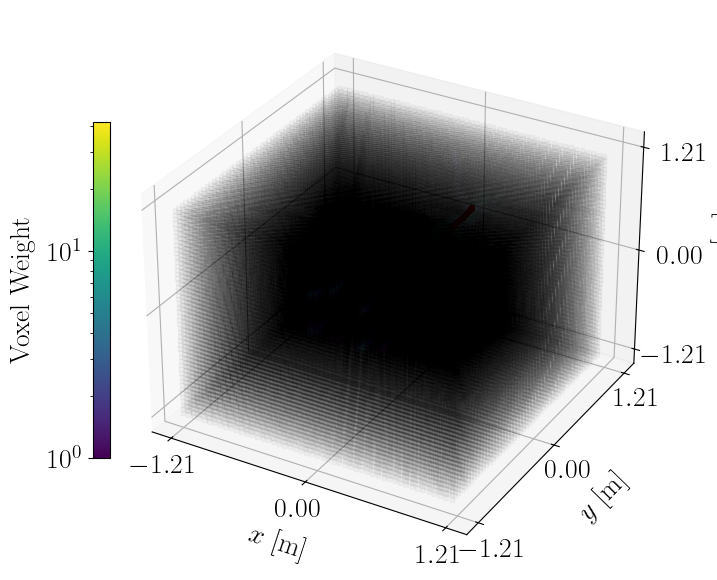

In [12]:
# %matplotlib qt
# %matplotlib inline

# colors = cm.viridis(np.linspace(0, 1, 1000))
# colors = ListedColormap(colors)
colors = cm.viridis
a=0
if makeErrors:
    a=0.045
else:
    a=0.03

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111, projection='3d')
fig.subplots_adjust(left=0.1, right=1.5, bottom=0.1, top=0.9)
voxelGrid = ax.scatter(grid_pos[:,0]/1000,
                       grid_pos[:,1]/1000,
                       grid_pos[:,2]/1000,  
                       c=grid[grid >= 0],
                       cmap=colors,
                       marker='s',
                       alpha=a,
                       s=10,
                       norm=LogNorm())  # Use LogNorm for log scale
track = ax.scatter(primary_true[:,0]/1000,
                   primary_true[:,1]/1000,
                   primary_true[:,2]/1000,
                   c='crimson',
                   marker='o',
                   s=5,
                   label='True Track',
                   linewidth=2)

ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
ax.set_zlabel('$z$ [m]')

ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 12
ax.zaxis.labelpad = 17

percExtra=1.1
ax.set_xlim(-DETECTOR_SIZE_X_MM/2/1000*percExtra, DETECTOR_SIZE_X_MM/2/1000*percExtra)
ax.set_ylim(-DETECTOR_SIZE_Y_MM/2/1000*percExtra, DETECTOR_SIZE_Y_MM/2/1000*percExtra)
ax.set_zlim(-DETECTOR_SIZE_Z_MM/2/1000*percExtra, DETECTOR_SIZE_Z_MM/2/1000*percExtra)

n=3
ax.set_xticks(np.linspace(-DETECTOR_SIZE_X_MM/2/1000, DETECTOR_SIZE_X_MM/2/1000, n))#[[1,-2, n//2]])
ax.set_yticks(np.linspace(-DETECTOR_SIZE_Y_MM/2/1000, DETECTOR_SIZE_Y_MM/2/1000, n))#[[1,-2, n//2]])
ax.set_zticks(np.linspace(-DETECTOR_SIZE_Z_MM/2/1000, DETECTOR_SIZE_Z_MM/2/1000, n))#[[1,-2, n//2]])

ax.tick_params(axis='x', pad=0)
ax.tick_params(axis='y', pad=1)
ax.tick_params(axis='z', pad=10)

# ax.set_title('Reconstruction Grid and True Track')
sm = plt.cm.ScalarMappable(cmap=colors, norm=LogNorm())
sm.set_array(grid[grid >= 0])
cbar = fig.colorbar(sm, ax=ax, shrink=0.6, pad=0.00, location='left')
cbar.set_label('Voxel Weight', labelpad=10)

# ax.legend(loc='center right', bbox_to_anchor=(1.8, 0.5))

# fig.tight_layout(rect=(0,0,1.2,1))
if savePlots:
    fig.savefig('../figures/trackReconstruction_gridAndTrack_{}.pdf'.format(plotRecoName))
fig.show()

# Plotting Methods

In [13]:
color_oranges = cm.Blues_r  ([0.5,0.6,0.9])
color_blues   = cm.Oranges_r([0.5,0.6,0.9])
blue_1 = "#B6CEC7"
blue_2 = "#92C1A5"
blue_3 = "#889D8E"
red_1  = "#C16464"
red_2  = "#B64D4D"
red_3  = "#FBE6E5"
twilight = cm.twilight(np.linspace(0,1,40))

# Mean Slice Reconstruction

In [14]:
import numpy as np
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.ndimage import rotate

from constants import *

def get_reconstructedPosition_slice(meanMax, grid, grid_ind, grid_pos, axis, 
                                    detector_size_1_mm=DETECTOR_SIZE_X_MM, detector_size_2_mm=DETECTOR_SIZE_Y_MM,
                                    saveAnimation=False, plotSlice=None, makeAnimation=None, saveDir=None, showPlots=False, savePlots=False):
    if meanMax != 'mean' and meanMax != 'max':
        raise ValueError('meanMax must be "mean" or "max"')
    
    grid_ind_tensor = np.reshape(grid_ind, grid.shape + (3,))
    grid_pos_tensor = np.reshape(grid_pos, grid.shape + (3,))

    # grid_ind_tensor = get_rotateIndTensor(grid_ind_tensor, axis)
    # oldBasis = np.eye(3)
    # newBasis = np.array([[0,0,1],
    #                      [0,1,0],
    #                      [1,0,0]])
    # grid_ind_tensor = get_changeOfBasis(grid_ind_tensor, oldBasis, newBasis)
    axes = get_axes(axis)

    pos_reco = np.ones((grid.shape[axis % 3], 3)) * np.nan

    # if axis % 3 == 0:
    #     pos_reco[:,axis % 3] = np.unique(np.reshape(grid_pos_tensor, (-1,3))[:,0])
    # elif axis % 3 == 1:
    #     pos_reco[:,axis % 3] = np.unique(np.reshape(grid_pos_tensor, (-1,3))[:,1])
    # elif axis % 3 == 2:
    #     pos_reco[:,axis % 3] = np.unique(np.reshape(grid_pos_tensor, (-1,3))[:,2])

    for i in tqdm.tqdm(np.arange(grid.shape[axis % 3])):
        pos_reco[i, axis % 3] = grid_pos_tensor[np.where(grid_ind_tensor[:,axis % 3] == i)][:,axis % 3].mean()

        ind, slice_grid, slice_pos = get_slice(grid, grid_ind_tensor, grid_pos_tensor, axis, i)

        # print('slice_grid:', slice_grid)
        # print('slice_pos:', slice_pos)

        if meanMax == 'mean':
            # slice_pos_0 = np.unique(slice_pos.reshape(-1,3)[:,0])
            # slice_pos_1 = np.unique(slice_pos.reshape(-1,3)[:,1])

            # val_1 = []
            # for sp0 in slice_pos_0:
            #     val_1.append(np.mean(slice_grid.reshape(-1)[np.where(slice_pos.reshape(-1,3)[:,0] == sp0)]))
            # val_1 = np.array(val_1)

            # val_2 = []
            # for sp1 in slice_pos_1:
            #     val_2.append(np.mean(slice_grid.reshape(-1)[np.where(slice_pos.reshape(-1,3)[:,1] == sp1)]))
            # val_2 = np.array(val_2)

            # if np.sum(val_1) == 0 or np.sum(val_2) == 0:
            #     continue
            
            # pos_reco[i,axes[0]] = np.average(slice_pos_0, weights=val_1)
            # pos_reco[i,axes[1]] = np.average(slice_pos_1, weights=val_2)

            ################################################################

            slice_pos_reshaped = slice_pos.reshape(-1, 3)
            slice_grid_reshaped = slice_grid.reshape(-1)

            # print('slice_pos_reshaped:', slice_pos_reshaped)
            # print('slice_grid_reshaped:', slice_grid_reshaped)
            # print()

            slice_pos_0 = np.unique(slice_pos_reshaped[:, axes[0]])
            slice_pos_1 = np.unique(slice_pos_reshaped[:, axes[1]])

            val_1 = np.array([np.mean(slice_grid_reshaped[slice_pos_reshaped[:, axes[0]] == sp0]) for sp0 in slice_pos_0])
            val_2 = np.array([np.mean(slice_grid_reshaped[slice_pos_reshaped[:, axes[1]] == sp1]) for sp1 in slice_pos_1])
            # print('val_1:', val_1)
            # print('val_2:', val_2)
            # print()

            if np.sum(val_1) != 0 and np.sum(val_2) != 0:
                pos_reco[i, axes[0]] = np.average(slice_pos_0, weights=val_1)
                pos_reco[i, axes[1]] = np.average(slice_pos_1, weights=val_2)

        elif meanMax == 'max':
            pos = grid_pos_tensor[np.where(grid_ind_tensor[:,axis % 3] == i)][:,np.flip(axes)]
            p = pos[np.argmax(np.reshape(grid_tensor.take(i, axis=axis), -1))]
            pos_reco[i,axes[0]] = p[0]
            pos_reco[i,axes[1]] = p[1]

        if saveAnimation:
            plotSlice(grid, pos_reco[i], i, axis, 
                      detector_size_1_mm, detector_size_2_mm, 
                      show=showPlots, save=savePlots, 
                      saveName='{}/{}_{}.pdf'.format(saveDir, axis, i))

    if saveAnimation:
        makeAnimation(grid, pos_reco[:], axis, 
                      detector_size_1_mm, detector_size_2_mm, 
                      save=savePlots, saveName='{}/{}.gif'.format(saveDir, axis))

    return pos_reco

def plotSlice(grid, pos, i, axis, 
              size_1, size_2, 
              ax=None, show=True, 
              save=False, saveName='test.png'):
    if ax is None:
        fig, ax = plt.subplots()

    if axis % 3 == 0:
        slice = grid[i,:,:]
    elif axis % 3 == 1:
        slice = grid[:,i,:]
    elif axis % 3 == 2:
        slice = grid[:,:,i]

    imshow = ax.imshow(slice, cmap='viridis', extent=[-size_1/2, size_1/2, size_2/2, -size_2/2])
    ax.scatter(pos[0], pos[1], c='r', marker='o', s=20)
    cbar = ax.figure.colorbar(imshow, ax=ax, label='Color Bar (Log Scale)')

    if show:
        plt.show()
    if save:
        plt.savefig(saveName)

    plt.close(fig)

def makeAnimation(grid, pos, axis, size_1, size_2, save=False, saveName='test.gif'):
    fig, ax = plt.subplots()

    def getSlice(i):
        if axis % 3 == 0:
            slice = grid[i,:,:]
        elif axis % 3 == 1:
            slice = grid[:,i,:]
        elif axis % 3 == 2:
            slice = grid[:,:,i]

        return slice

    imshow = ax.imshow(getSlice(0), cmap='viridis', extent=[-size_1/2, size_1/2, size_2/2, -size_2/2])
    scatter = ax.scatter(pos[0,0], pos[0,1], c='r', marker='o', s=20)
    cbar = ax.figure.colorbar(imshow, ax=ax)

    def update(i):
        slice = getSlice(i)

        imshow.set_data(slice)
        scatter.set_offsets(pos[i,:])
            
        return imshow, scatter
        
    anim = FuncAnimation(fig, update, frames=np.arange(1, grid.shape[0]-1), interval=100)
    anim.save(saveName, dpi=80, writer='imagemagick')
    return anim

def get_axes(axis):
    if axis % 3 == 0:
        axes = [1,2]
    elif axis % 3 == 1:
        axes = [0,2]
    elif axis % 3 == 2:
        axes = [0,1]
    else:
        raise ValueError('axis must be 0, 1, 2, 3, 4, or 5')

    return axes

def get_changeOfBasis_matrix(oldBasis, newBasis):
    return np.linalg.inv(oldBasis) @ newBasis

def get_changeOfBasis(pos_tensor, oldBasis, newBasis):
    return (pos_tensor.reshape(-1,3) @ get_changeOfBasis_matrix(oldBasis, newBasis)).reshape(pos_tensor.shape)

def get_slice(grid, grid_ind_tensor, grid_pos_tensor, axis, i):
    # ind = grid_ind_tensor.take(i, axis=axis % 3)
    # slice_grid = grid           [ind[:,:,0], ind[:,:,1], ind[:,:,2]]
    # slice_pos  = grid_pos_tensor[ind[:,:,0], ind[:,:,1], ind[:,:,2]]
    ind = np.array(grid_ind_tensor.take(i, axis=axis % 3)).reshape(-1,3).astype(int)
    slice_grid = grid           [ind[:,0], ind[:,1], ind[:,2]]
    slice_pos  = grid_pos_tensor[ind[:,0], ind[:,1], ind[:,2]]

    return ind, slice_grid, slice_pos

In [15]:
showPlots = False
savePlots = False
saveAnima = False
saveDir = '../figures/voxelGrid_mean_{}'.format(plotRecoName)

X_mean = get_reconstructedPosition_slice('mean', grid, grid_ind, grid_pos, 0, DETECTOR_SIZE_Y_MM, DETECTOR_SIZE_Z_MM, saveAnimation=saveAnima, plotSlice=plotSlice, makeAnimation=makeAnimation, saveDir=saveDir, showPlots=showPlots, savePlots=savePlots)
print('X_mean.shape:', X_mean.shape)
print('X_mean:', X_mean)
Y_mean = get_reconstructedPosition_slice('mean', grid, grid_ind, grid_pos, 1, DETECTOR_SIZE_X_MM, DETECTOR_SIZE_Z_MM, saveAnimation=saveAnima, plotSlice=plotSlice, makeAnimation=makeAnimation, saveDir=saveDir, showPlots=showPlots, savePlots=savePlots)
Z_mean = get_reconstructedPosition_slice('mean', grid, grid_ind, grid_pos, 2, DETECTOR_SIZE_X_MM, DETECTOR_SIZE_Y_MM, saveAnimation=saveAnima, plotSlice=plotSlice, makeAnimation=makeAnimation, saveDir=saveDir, showPlots=showPlots, savePlots=savePlots)
A_mean = get_reconstructedPosition_slice('mean', grid, grid_ind, grid_pos, 3, DETECTOR_SIZE_X_MM, DETECTOR_SIZE_Y_MM, saveAnimation=saveAnima, plotSlice=plotSlice, makeAnimation=makeAnimation, saveDir=saveDir, showPlots=showPlots, savePlots=savePlots)
B_mean = get_reconstructedPosition_slice('mean', grid, grid_ind, grid_pos, 4, DETECTOR_SIZE_X_MM, DETECTOR_SIZE_Y_MM, saveAnimation=saveAnima, plotSlice=plotSlice, makeAnimation=makeAnimation, saveDir=saveDir, showPlots=showPlots, savePlots=savePlots)
C_mean = get_reconstructedPosition_slice('mean', grid, grid_ind, grid_pos, 5, DETECTOR_SIZE_X_MM, DETECTOR_SIZE_Y_MM, saveAnimation=saveAnima, plotSlice=plotSlice, makeAnimation=makeAnimation, saveDir=saveDir, showPlots=showPlots, savePlots=savePlots)

avg_mean = np.mean(np.array([X_mean,Y_mean,Z_mean]), axis=0)

100%|██████████| 50/50 [00:00<00:00, 693.26it/s]


X_mean.shape: (50, 3)
X_mean: [[  -47.00384615            nan            nan]
 [ -592.9                   nan            nan]
 [ -568.7                   nan            nan]
 [ -544.5                   nan            nan]
 [ -520.3                   nan            nan]
 [ -496.1                   nan            nan]
 [ -471.9                   nan            nan]
 [ -447.7                   nan            nan]
 [ -423.5                   nan            nan]
 [ -399.3                   nan            nan]
 [ -375.1                   nan            nan]
 [ -350.9                   nan            nan]
 [ -326.7                   nan            nan]
 [ -302.5                   nan            nan]
 [ -278.3                   nan            nan]
 [ -254.1                   nan            nan]
 [ -229.9                   nan            nan]
 [ -205.7                   nan            nan]
 [ -181.5                   nan            nan]
 [ -157.3                   nan            nan]
 [ -133.1 

100%|██████████| 50/50 [00:00<00:00, 776.89it/s]


In [16]:
print('X_mean:', X_mean.shape)
print('Y_mean:', Y_mean.shape)
print('Z_mean:', Z_mean.shape)
print('A_mean:', A_mean.shape)
print('B_mean:', B_mean.shape)
print('C_mean:', C_mean.shape)

print('X_mean[0]:', X_mean[0])
print('Y_mean[0]:', Y_mean[0])
print('Z_mean[0]:', Z_mean[0])
print('A_mean[0]:', A_mean[0])
print('B_mean[0]:', B_mean[0])
print('C_mean[0]:', C_mean[0])

X_mean: (50, 3)
Y_mean: (50, 3)
Z_mean: (50, 3)
A_mean: (50, 3)
B_mean: (50, 3)
C_mean: (50, 3)
X_mean[0]: [-47.00384615          nan          nan]
Y_mean[0]: [ 190.31864407 -617.1         444.62372881]
Z_mean[0]: [  266.2   968.  -1161.6]
A_mean[0]: [-47.00384615          nan          nan]
B_mean[0]: [ 190.31864407 -617.1         444.62372881]
C_mean[0]: [  266.2   968.  -1161.6]


In [17]:
A_xz = np.vstack([avg_mean[:,0], np.ones(len(avg_mean[:,0]))]).T
m_xz, c_xz = np.linalg.lstsq(A_xz, avg_mean[:,1])[0]

A_yz = np.vstack([avg_mean[:,1], np.ones(len(avg_mean[:,1]))]).T
m_yz, c_yz = np.linalg.lstsq(A_yz, avg_mean[:,2])[0]

def lin(z):
    x = (z - c_xz)/m_xz
    y = (z - c_yz)/m_yz
    return x, y

zz = primary_true[:,2]
xx, yy = lin(zz)

avg_mean_lin = np.array([xx, yy, zz]).T

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_66503/4160363666.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m_xz, c_xz = np.linalg.lstsq(A_xz, avg_mean[:,1])[0]
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_66503/4160363666.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m_yz, c_yz = np.linalg.lstsq(A_yz, avg_mean[:,2])[0]


LinAlgError: SVD did not converge in Linear Least Squares

 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_66503/1375227958.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


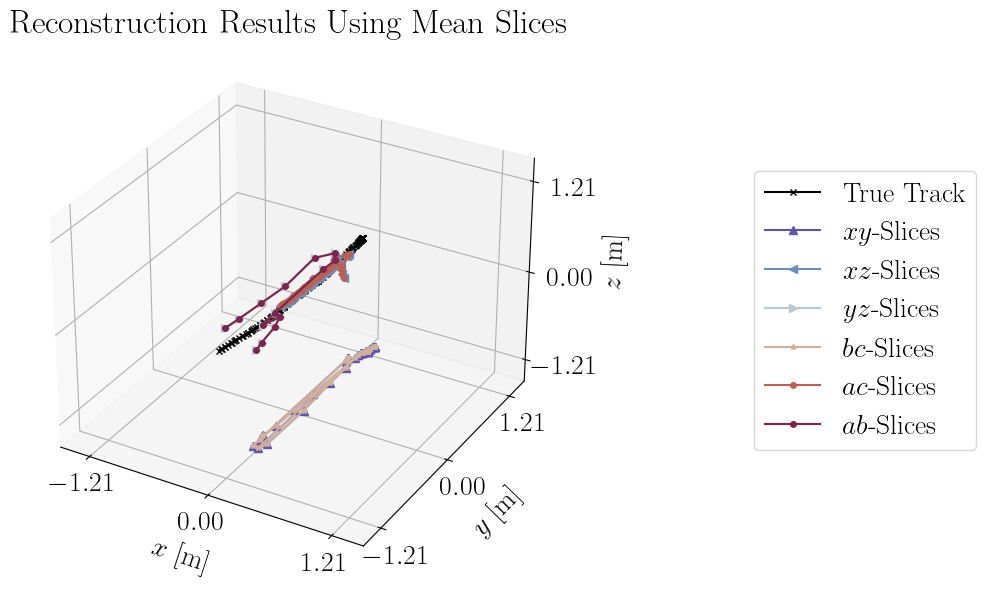

In [18]:
# %matplotlib qt
# %matplotlib inline

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

# voxelGrid       = ax.scatter(grid_pos    [:,0]/1000, grid_pos    [:,1]/1000, grid_pos    [:,2]/1000, c=grid[grid >= 0], cmap='viridis', marker='D', alpha=0.02, s=10, norm=LogNorm())  # Use LogNorm for log scale
track_true      = ax.plot(primary_true[:,0]/1000, primary_true[:,1]/1000, primary_true[:,2]/1000, c='black'       , marker='x', markersize=5, label='True Track' , linewidth=1.5)
track_reco_Z    = ax.plot(Z_mean      [:,0]/1000, Z_mean      [:,1]/1000, Z_mean      [:,2]/1000, c=twilight[12,:], marker='^', markersize=6, label='$xy$-Slices', linewidth=1.5)
track_reco_Y    = ax.plot(Y_mean      [:,0]/1000, Y_mean      [:,1]/1000, Y_mean      [:,2]/1000, c=twilight[8 ,:], marker='<', markersize=6, label='$xz$-Slices', linewidth=1.5)
track_reco_X    = ax.plot(X_mean      [:,0]/1000, X_mean      [:,1]/1000, X_mean      [:,2]/1000, c=twilight[3 ,:], marker='>', markersize=6, label='$yz$-Slices', linewidth=1.5)
track_reco_C    = ax.plot(C_mean      [:,0]/1000, C_mean      [:,1]/1000, C_mean      [:,2]/1000, c=twilight[35,:], marker='*', markersize=4, label='$bc$-Slices', linewidth=1.5)
track_reco_B    = ax.plot(B_mean      [:,0]/1000, B_mean      [:,1]/1000, B_mean      [:,2]/1000, c=twilight[30,:], marker='o', markersize=4, label='$ac$-Slices', linewidth=1.5)
track_reco_A    = ax.plot(A_mean      [:,0]/1000, A_mean      [:,1]/1000, A_mean      [:,2]/1000, c=twilight[25,:], marker='o', markersize=4, label='$ab$-Slices', linewidth=1.5)
# track_reco      = ax.plot(avg_mean    [:,0]/1000, avg_mean    [:,1]/1000, avg_mean    [:,2]/1000, c=twilight[35,:], marker='*', markersize=6, label='Average'    , linewidth=1.5)
# track_reco_line = ax.plot(avg_mean_lin[:,0]/1000, avg_mean_lin[:,1]/1000, avg_mean_lin[:,2]/1000, c=twilight[30,:], marker='o', markersize=0, label='Linear Fit' , linewidth=1.5)

ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
ax.set_zlabel('$z$ [m]')

ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 12
ax.zaxis.labelpad = 17

percExtra=1.2
ax.set_xlim(-DETECTOR_SIZE_X_MM/2/1000*percExtra, DETECTOR_SIZE_X_MM/2/1000*percExtra)
ax.set_ylim(-DETECTOR_SIZE_Y_MM/2/1000*percExtra, DETECTOR_SIZE_Y_MM/2/1000*percExtra)
ax.set_zlim(-DETECTOR_SIZE_Z_MM/2/1000*percExtra, DETECTOR_SIZE_Z_MM/2/1000*percExtra)

n=3
ax.set_xticks(np.linspace(-DETECTOR_SIZE_X_MM/2/1000, DETECTOR_SIZE_X_MM/2/1000, n))#[[1,-2, n//2]])
ax.set_yticks(np.linspace(-DETECTOR_SIZE_Y_MM/2/1000, DETECTOR_SIZE_Y_MM/2/1000, n))#[[1,-2, n//2]])
ax.set_zticks(np.linspace(-DETECTOR_SIZE_Z_MM/2/1000, DETECTOR_SIZE_Z_MM/2/1000, n))#[[1,-2, n//2]])

ax.tick_params(axis='x', pad=0)
ax.tick_params(axis='y', pad=2)
ax.tick_params(axis='z', pad=10)

ax.set_title('Reconstruction Results Using Mean Slices')
ax.set_title('Reconstruction Results Using Mean Slices', loc='center')

sm = plt.cm.ScalarMappable(cmap='viridis', norm=LogNorm())
sm.set_array(grid[grid > 0])
# cbar = fig.colorbar(sm, ax=ax, label='Color Bar (Log Scale)')

ax.legend(loc='center right', bbox_to_anchor=(1.8, 0.5))

if savePlots:
    fig.savefig('../figures/trackReconstruction_mean_{}.pdf'.format(plotRecoName), bbox_inches='tight')
fig.show()

In [ ]:
distances_X = cdist(primary_true, X_mean)
distances_X = np.min(distances_X, axis=1)

distances_Y = cdist(primary_true, Y_mean)
distances_Y = np.min(distances_Y, axis=1)

distances_Z = cdist(primary_true, Z_mean)
distances_Z = np.min(distances_Z, axis=1)

distances_pts = cdist(primary_true, avg_mean)
distances_pts = np.min(distances_pts, axis=1)

distances_pts_lin = cdist(primary_true, avg_mean_lin)
distances_pts_lin = np.min(distances_pts_lin, axis=1)

scale = 10
lw = 3
nBins = 50
alpha1 = 0.5
alpha2 = 1

PDF, _, _, bins = get_PDF(distances_pts/scale, nBins=nBins)
sigma_1_avg = get_CSP('1 sigma', PDF=PDF, bins=bins)
sigma_2_avg = get_CSP('2 sigma', PDF=PDF, bins=bins)
PDF, _, _, bins = get_PDF(distances_pts_lin/scale, nBins=nBins)
sigma_1_avg_lin = get_CSP('1 sigma', PDF=PDF, bins=bins)
sigma_2_avg_lin = get_CSP('2 sigma', PDF=PDF, bins=bins)

fig, ax_2 = plt.subplots(1, 1, figsize=(5,5))
bins = np.linspace(0, np.max([np.max(distances_X/scale), np.max(distances_Y/scale), np.max(distances_Z/scale), np.max(distances_pts/scale)]), nBins)

hist_X      , bins_X      , _ = ax_2.hist(distances_X      /scale, bins=bins, color=twilight[3 ,:], alpha=alpha2,                     histtype='step'      , cumulative=True, density=True, linewidth=lw, zorder=-1)
hist_Y      , bins_Y      , _ = ax_2.hist(distances_Y      /scale, bins=bins, color=twilight[8 ,:], alpha=alpha2,                     histtype='step'      , cumulative=True, density=True, linewidth=lw, zorder= 0)
hist_Z      , bins_Z      , _ = ax_2.hist(distances_Z      /scale, bins=bins, color=twilight[12,:], alpha=alpha2,                     histtype='step'      , cumulative=True, density=True, linewidth=lw, zorder=-2)
hist_pts    , bins_pts    , _ = ax_2.hist(distances_pts    /scale, bins=bins, color=twilight[35,:], alpha=alpha2,                     histtype='step'      , cumulative=True, density=True, linewidth=lw, zorder=-4)
hist_pts_lin, bins_pts_lin, _ = ax_2.hist(distances_pts_lin/scale, bins=bins, color=twilight[30,:], alpha=alpha2,                     histtype='step'      , cumulative=True, density=True, linewidth=lw, zorder=-3)

ax_2.fill_between(bins_Z      [1:], hist_Z      , 0, color='white', linewidth=lw, alpha=1, step='pre', edgecolor=tuple(twilight[12,:]), hatch=r'||' , zorder=-7, label='$xy$-Slices')
ax_2.fill_between(bins_Y      [1:], hist_Y      , 0, color='white', linewidth=lw, alpha=1, step='pre', edgecolor=tuple(twilight[8 ,:]), hatch=r'-\\', zorder=-5, label='$xz$-Slices')
ax_2.fill_between(bins_X      [1:], hist_X      , 0, color='white', linewidth=lw, alpha=1, step='pre', edgecolor=tuple(twilight[3 ,:]), hatch=r'//' , zorder=-6, label='$yz$-Slices')
ax_2.fill_between(bins_pts    [1:], hist_pts    , 0, color='white', linewidth=lw, alpha=1, step='pre', edgecolor=tuple(twilight[35,:]), hatch=r'--' , zorder=-9, label='Average'   )
ax_2.fill_between(bins_pts_lin[1:], hist_pts_lin, 0, color='white', linewidth=lw, alpha=1, step='pre', edgecolor=tuple(twilight[30,:]), hatch=r'\\' , zorder=-8, label='Linear Fit')

ax_2.plot([sigma_1_avg    , sigma_1_avg    , 0], [0, 0.68, 0.68], color=twilight[35,:], linewidth=1.5, alpha=0.9, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()], linestyle='--')
ax_2.plot([sigma_2_avg    , sigma_2_avg    , 0], [0, 0.95, 0.95], color=twilight[35,:], linewidth=1.5, alpha=0.9, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()], linestyle='--')
ax_2.plot([sigma_1_avg_lin, sigma_1_avg_lin, 0], [0, 0.68, 0.68], color=twilight[30,:], linewidth=1.5, alpha=0.9, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()], linestyle='--')
ax_2.plot([sigma_2_avg_lin, sigma_2_avg_lin, 0], [0, 0.95, 0.95], color=twilight[30,:], linewidth=1.5, alpha=0.9, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()], linestyle='--')

ax_2.set_xlabel('Point Error [cm]')
ax_2.set_ylabel('Cumulative Density')
ax_2.set_xlim(xmin=0, xmax=100)
# ax_2.legend(loc='lower right')
ax_2.grid()

if savePlots:
    fig.savefig('../figures/trackReconstruction_meanError_{}.pdf'.format(plotRecoName), bbox_inches='tight')
fig.show()

NameError: name 'avg_mean_lin' is not defined

In [ ]:
relativeVectors = []
errors = []
for i in tqdm.tqdm(range(len(df_hits))):
    relativeVectors.append(df_hits['relativeVector_r'].iloc[i]/scale)
    initialPosition = df_hits['initialPosition'].iloc[i]
    error = cdist([initialPosition], avg_mean)
    error = np.min(error, axis=1)[0]/scale
    errors.append(error)
relativeVectors = np.array(relativeVectors)
errors = np.array(errors)

fig, ax = plt.subplots(figsize=(8, 6))
h, xedges, yedges, _ = ax.hist2d(
    relativeVectors,
    errors,
    norm=LogNorm(),
    bins=50
)
yaverage = []
xaverage = []
for i in range(h.shape[1]):
    if np.sum(h[i,:]) != 0:
        yaverage.append(np.average(yedges[:-1], weights=h[i,:]))
        xaverage.append(xedges[i] + (xedges[i+1] - xedges[i])/2)

ax.plot(
    xaverage,
    yaverage,
    color='r',
    linewidth=3,
    label='Mean Error'
)
ax.set_xlabel('Photon Distance [cm]')
ax.set_ylabel('Error [cm]')
ax.set_title('Mean Error vs Photon Distance')
fig.colorbar(ax.collections[0]) 
ax.legend(loc='upper right')

if savePlots:
    fig.savefig('../figures/trackReconstruction_meanErrorVsPhotonDistance_{}.pdf'.format(plotRecoName), bbox_inches='tight')
fig.show()

  0%|          | 0/61 [00:00<?, ?it/s]


NameError: name 'scale' is not defined

# Max Slice Reconstruction

100%|██████████| 50/50 [00:00<00:00, 72.92it/s]


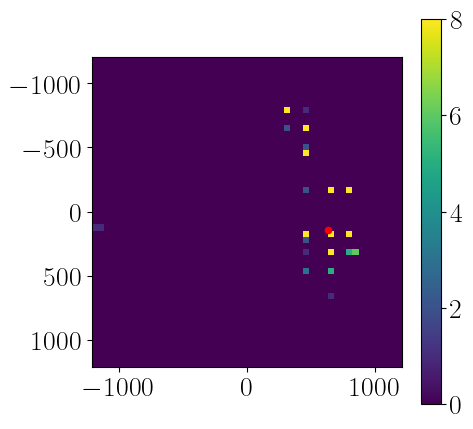

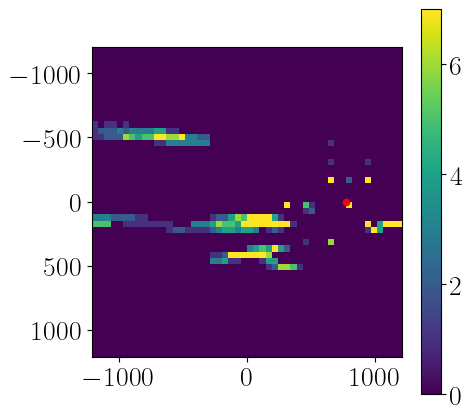

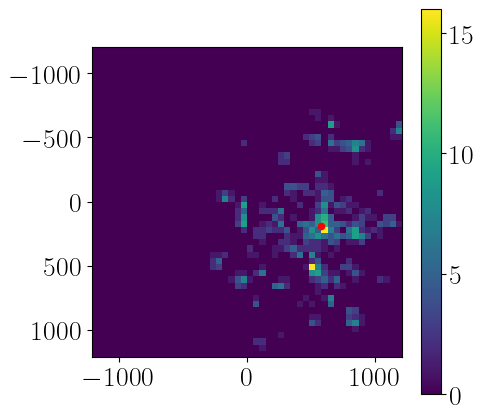

In [ ]:
showPlots = False
savePlots = False
saveAnima = True
saveDir = '../figures/voxelGrid_max_{}'.format(plotRecoName)

X_max = get_reconstructedPosition_slice('max', grid, grid_ind, grid_pos, 0, DETECTOR_SIZE_Y_MM, DETECTOR_SIZE_Z_MM, saveAnimation=saveAnima, plotSlice=plotSlice, makeAnimation=makeAnimation, saveDir=saveDir, showPlots=showPlots, savePlots=savePlots)
Y_max = get_reconstructedPosition_slice('max', grid, grid_ind, grid_pos, 1, DETECTOR_SIZE_X_MM, DETECTOR_SIZE_Z_MM, saveAnimation=saveAnima, plotSlice=plotSlice, makeAnimation=makeAnimation, saveDir=saveDir, showPlots=showPlots, savePlots=savePlots)
Z_max = get_reconstructedPosition_slice('max', grid, grid_ind, grid_pos, 2, DETECTOR_SIZE_X_MM, DETECTOR_SIZE_Y_MM, saveAnimation=saveAnima, plotSlice=plotSlice, makeAnimation=makeAnimation, saveDir=saveDir, showPlots=showPlots, savePlots=savePlots)

avg_max = np.mean(np.array([X_max,Y_max,Z_max]), axis=0)

In [ ]:
A_xz = np.vstack([avg_max[:,0], np.ones(len(avg_max[:,0]))]).T
m_xz, c_xz = np.linalg.lstsq(A_xz, avg_max[:,1])[0]

A_yz = np.vstack([avg_max[:,1], np.ones(len(avg_max[:,1]))]).T
m_yz, c_yz = np.linalg.lstsq(A_yz, avg_max[:,2])[0]

def lin(z):
    x = (z - c_xz)/m_xz
    y = (z - c_yz)/m_yz
    return x, y

zz = primary_true[:,2]
xx, yy = lin(zz)

avg_max_lin = np.array([xx, yy, zz]).T

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_69716/947378831.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m_xz, c_xz = np.linalg.lstsq(A_xz, avg_max[:,1])[0]
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_69716/947378831.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m_yz, c_yz = np.linalg.lstsq(A_yz, avg_max[:,2])[0]


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_69716/2299556833.py:48: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


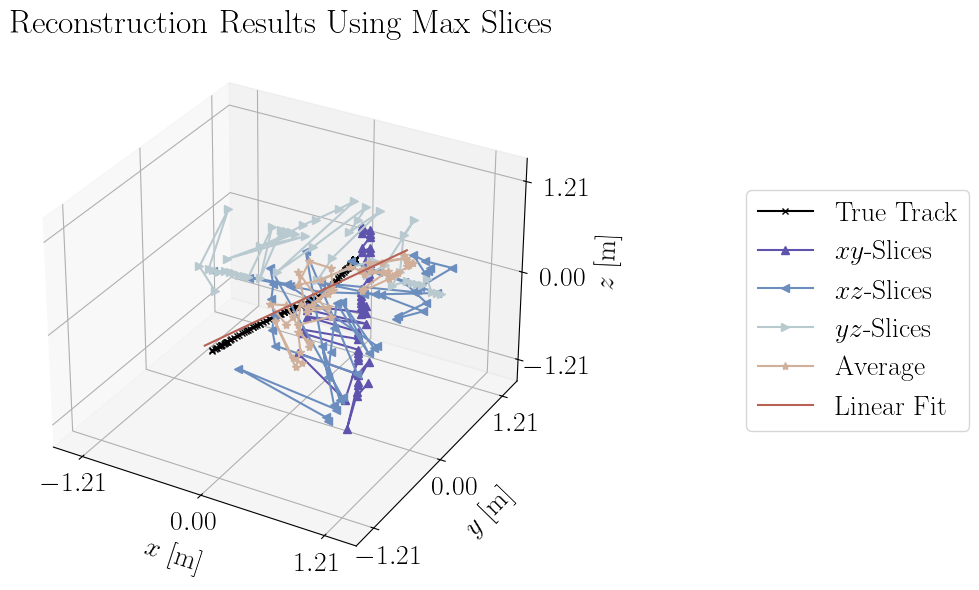

In [ ]:
# %matplotlib qt
# %matplotlib inline

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

# voxelGrid       = ax.scatter(grid_pos    [:,0]/1000, grid_pos    [:,1]/1000, grid_pos    [:,2]/1000, c=grid[grid >= 0], cmap='viridis', marker='D', alpha=0.02, s=10, norm=LogNorm())  # Use LogNorm for log scale
track_true      = ax.plot(primary_true[:,0]/1000, primary_true[:,1]/1000, primary_true[:,2]/1000, c='black'       , marker='x', markersize=5, label='True Track' , linewidth=1.5)
track_reco_Z    = ax.plot(Z_max       [:,0]/1000, Z_max       [:,1]/1000, Z_max       [:,2]/1000, c=twilight[12,:], marker='^', markersize=6, label='$xy$-Slices', linewidth=1.5)
track_reco_Y    = ax.plot(Y_max       [:,0]/1000, Y_max       [:,1]/1000, Y_max       [:,2]/1000, c=twilight[8 ,:], marker='<', markersize=6, label='$xz$-Slices', linewidth=1.5)
track_reco_X    = ax.plot(X_max       [:,0]/1000, X_max       [:,1]/1000, X_max       [:,2]/1000, c=twilight[3 ,:], marker='>', markersize=6, label='$yz$-Slices', linewidth=1.5)
track_reco      = ax.plot(avg_max     [:,0]/1000, avg_max     [:,1]/1000, avg_max     [:,2]/1000, c=twilight[35,:], marker='*', markersize=6, label='Average'    , linewidth=1.5)
track_reco_line = ax.plot(avg_max_lin [:,0]/1000, avg_max_lin [:,1]/1000, avg_max_lin [:,2]/1000, c=twilight[30,:], marker='o', markersize=0, label='Linear Fit' , linewidth=1.5)

ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
ax.set_zlabel('$z$ [m]')

ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 12
ax.zaxis.labelpad = 17

percExtra=1.2
ax.set_xlim(-DETECTOR_SIZE_X_MM/2/1000*percExtra, DETECTOR_SIZE_X_MM/2/1000*percExtra)
ax.set_ylim(-DETECTOR_SIZE_Y_MM/2/1000*percExtra, DETECTOR_SIZE_Y_MM/2/1000*percExtra)
ax.set_zlim(-DETECTOR_SIZE_Z_MM/2/1000*percExtra, DETECTOR_SIZE_Z_MM/2/1000*percExtra)

n=3
ax.set_xticks(np.linspace(-DETECTOR_SIZE_X_MM/2/1000, DETECTOR_SIZE_X_MM/2/1000, n))#[[1,-2, n//2]])
ax.set_yticks(np.linspace(-DETECTOR_SIZE_Y_MM/2/1000, DETECTOR_SIZE_Y_MM/2/1000, n))#[[1,-2, n//2]])
ax.set_zticks(np.linspace(-DETECTOR_SIZE_Z_MM/2/1000, DETECTOR_SIZE_Z_MM/2/1000, n))#[[1,-2, n//2]])

ax.tick_params(axis='x', pad=0)
ax.tick_params(axis='y', pad=2)
ax.tick_params(axis='z', pad=10)

ax.set_title('Reconstruction Results Using Max Slices')
ax.set_title('Reconstruction Results Using Max Slices', loc='center')

sm = plt.cm.ScalarMappable(cmap='viridis', norm=LogNorm())
sm.set_array(grid[grid > 0])
# cbar = fig.colorbar(sm, ax=ax, label='Color Bar (Log Scale)')

ax.legend(loc='center right', bbox_to_anchor=(1.8, 0.5))

if savePlots:
    fig.savefig('../figures/trackReconstruction_max_{}.pdf'.format(plotRecoName), bbox_inches='tight')
fig.show()


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_69716/4153076661.py:62: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 500x500 with 0 Axes>

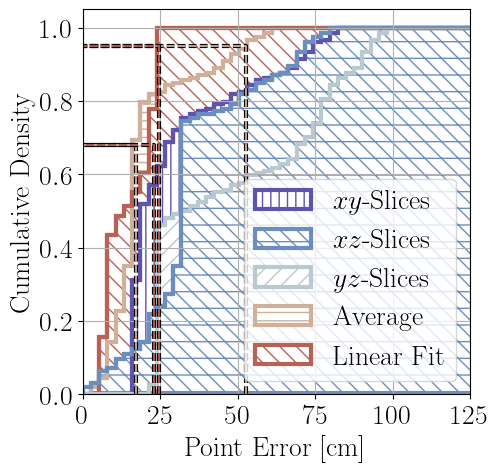

In [ ]:
# %matplotlib inline

distances_X = cdist(primary_true, X_max)
distances_X = np.min(distances_X, axis=1)

distances_Y = cdist(primary_true, Y_max)
distances_Y = np.min(distances_Y, axis=1)

distances_Z = cdist(primary_true, Z_max)
distances_Z = np.min(distances_Z, axis=1)

distances_pts = cdist(primary_true, avg_max)
distances_pts = np.min(distances_pts, axis=1)

distances_pts_lin = cdist(primary_true, avg_max_lin)
distances_pts_lin = np.min(distances_pts_lin, axis=1)

scale = 10
lw = 3
nBins = 50
alpha1 = 0.5
alpha2 = 1

PDF, _, _, bins = get_PDF(distances_pts/scale, nBins=nBins)
sigma_1_max = get_CSP('1 sigma', PDF=PDF, bins=bins)
sigma_2_max = get_CSP('2 sigma', PDF=PDF, bins=bins)
PDF, _, _, bins = get_PDF(distances_pts_lin/scale, nBins=nBins)
sigma_1_max_lin = get_CSP('1 sigma', PDF=PDF, bins=bins)
sigma_2_max_lin = get_CSP('2 sigma', PDF=PDF, bins=bins)

fig, ax_2 = plt.subplots(1, 1, figsize=(5, 5))
# max_val = np.max([np.max(distances_X/scale), np.max(distances_Y/scale), np.max(distances_Z/scale), np.max(distances_pts/scale), np.max(distances_pts_lin/scale)])
max_val = 130
bins = np.linspace(0, max_val, nBins)

hist_X      , bins_X      , _ = ax_2.hist(distances_X      /scale, bins=bins, color=twilight[3 ,:], alpha=alpha2,                     histtype='step'      , cumulative=True, density=True, linewidth=lw, zorder=-1)
hist_Y      , bins_Y      , _ = ax_2.hist(distances_Y      /scale, bins=bins, color=twilight[8 ,:], alpha=alpha2,                     histtype='step'      , cumulative=True, density=True, linewidth=lw, zorder= 0)
hist_Z      , bins_Z      , _ = ax_2.hist(distances_Z      /scale, bins=bins, color=twilight[12,:], alpha=alpha2,                     histtype='step'      , cumulative=True, density=True, linewidth=lw, zorder=-2)
hist_pts    , bins_pts    , _ = ax_2.hist(distances_pts    /scale, bins=bins, color=twilight[35,:], alpha=alpha2,                     histtype='step'      , cumulative=True, density=True, linewidth=lw, zorder=-4)
hist_pts_lin, bins_pts_lin, _ = ax_2.hist(distances_pts_lin/scale, bins=bins, color=twilight[30,:], alpha=alpha2,                     histtype='step'      , cumulative=True, density=True, linewidth=lw, zorder=-3)

ax_2.fill_between(bins_Z      [1:], hist_Z      , 0, color='white', linewidth=lw, alpha=1, step='pre', edgecolor=tuple(twilight[12,:]), hatch=r'||' , zorder=-7, label='$xy$-Slices')
ax_2.fill_between(bins_Y      [1:], hist_Y      , 0, color='white', linewidth=lw, alpha=1, step='pre', edgecolor=tuple(twilight[8 ,:]), hatch=r'-\\', zorder=-5, label='$xz$-Slices')
ax_2.fill_between(bins_X      [1:], hist_X      , 0, color='white', linewidth=lw, alpha=1, step='pre', edgecolor=tuple(twilight[3 ,:]), hatch=r'//' , zorder=-6, label='$yz$-Slices')
ax_2.fill_between(bins_pts    [1:], hist_pts    , 0, color='white', linewidth=lw, alpha=1, step='pre', edgecolor=tuple(twilight[35,:]), hatch=r'--' , zorder=-9, label='Average'   )
ax_2.fill_between(bins_pts_lin[1:], hist_pts_lin, 0, color='white', linewidth=lw, alpha=1, step='pre', edgecolor=tuple(twilight[30,:]), hatch=r'\\' , zorder=-8, label='Linear Fit')

ax_2.plot([sigma_1_max    , sigma_1_max    , 0], [0, 0.68, 0.68], color=twilight[35,:], linewidth=1.5, alpha=0.9, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()], linestyle='--')
ax_2.plot([sigma_2_max    , sigma_2_max    , 0], [0, 0.95, 0.95], color=twilight[35,:], linewidth=1.5, alpha=0.9, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()], linestyle='--')
ax_2.plot([sigma_1_max_lin, sigma_1_max_lin, 0], [0, 0.68, 0.68], color=twilight[30,:], linewidth=1.5, alpha=0.9, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()], linestyle='--')
ax_2.plot([sigma_2_max_lin, sigma_2_max_lin, 0], [0, 0.95, 0.95], color=twilight[30,:], linewidth=1.5, alpha=0.9, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()], linestyle='--')

ax_2.set_xlabel('Point Error [cm]')
ax_2.set_ylabel('Cumulative Density')
ax_2.set_xticks([0, 25, 50, 75, 100, 125])
ax_2.set_xlim(xmin=0, xmax=max_val-5)
ax_2.legend(loc='lower right')
ax_2.grid()

if savePlots:
    fig.savefig('../figures/trackReconstruction_maxError_{}.pdf'.format(plotRecoName), bbox_inches='tight')
fig.show()

100%|██████████| 1195/1195 [00:00<00:00, 59217.08it/s]
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_69716/889251872.py:41: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


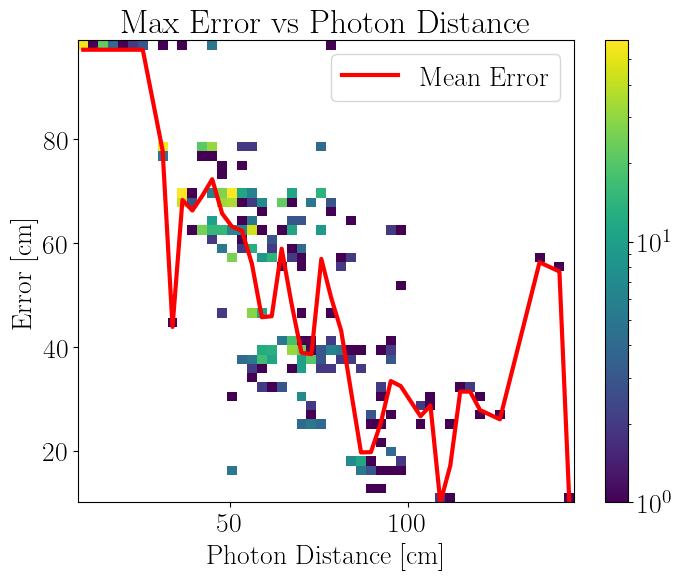

In [ ]:
relativeVectors = []
errors = []
for i in tqdm.tqdm(range(len(df_hits))):
    relativeVectors.append(df_hits['relativeVector_r'].iloc[i]/scale)
    initialPosition = df_hits['initialPosition'].iloc[i]
    error = cdist([initialPosition], avg_max)
    error = np.min(error, axis=1)[0]/scale
    errors.append(error)
relativeVectors = np.array(relativeVectors)
errors = np.array(errors)

fig, ax = plt.subplots(figsize=(8, 6))
h, xedges, yedges, _ = ax.hist2d(
    relativeVectors,
    errors,
    norm=LogNorm(),
    bins=50
)
yaverage = []
xaverage = []
for i in range(h.shape[1]):
    if np.sum(h[i,:]) != 0:
        yaverage.append(np.average(yedges[:-1], weights=h[i,:]))
        xaverage.append(xedges[i] + (xedges[i+1] - xedges[i])/2)

ax.plot(
    xaverage,
    yaverage,
    color='r',
    linewidth=3,
    label='Mean Error'
)
ax.set_xlabel('Photon Distance [cm]')
ax.set_ylabel('Error [cm]')
ax.set_title('Max Error vs Photon Distance')
fig.colorbar(ax.collections[0]) 
ax.legend(loc='upper right')

if savePlots:
    fig.savefig('../figures/trackReconstruction_maxErrorVsPhotonDistance_{}.pdf'.format(plotRecoName), bbox_inches='tight')
fig.show()